In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score,accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [3]:
Dataset = pd.read_csv('./CE802_P3_Data/CE802_P3_Data.csv')
Dataset.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target
0,193.83,UK,49.74,14.16,213.02,343.06,1753.44,-6.03,6.28,8,-5145.92,Low,11.35,1.01,1,68.92,51.16
1,1495.47,Europe,58.02,5.88,137.80,270.48,1665.33,-0.52,9.72,14,11145.82,High,10.30,0.30,5,89.30,0.00
2,1121.31,USA,68.85,9.18,209.54,295.26,3208.65,-4.00,3.86,6,31859.00,Medium,7.98,13.05,4,-11.80,2808.51
3,-305.49,USA,49.29,8.73,171.83,266.06,1704.18,-2.41,4.16,6,8075.76,Low,16.52,2.01,5,41.40,1092.21
4,1457.07,UK,64.98,7.92,74.10,260.22,1922.34,-11.97,5.00,18,9886.72,High,5.37,0.01,1,62.74,0.00


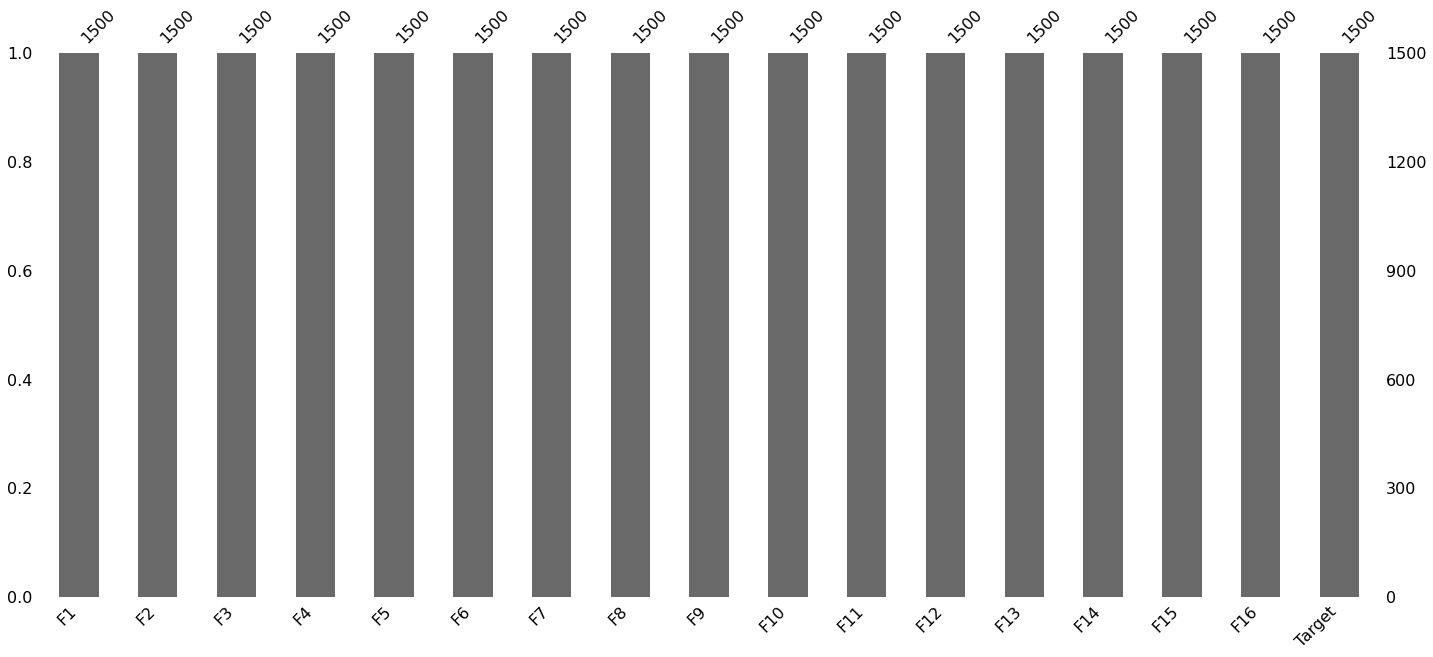

In [4]:
#Checking if there is any null values
msno.bar(Dataset) 

Text(0.5, 1.0, 'Correlation Matrix')

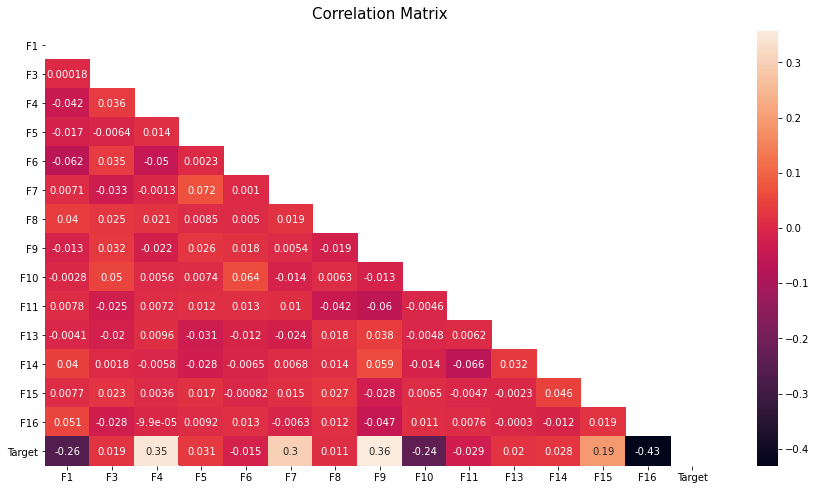

In [5]:
# build the co-relation martix
mask = np.triu(np.ones_like(Dataset.corr(), dtype=np.bool))
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(Dataset.corr(), annot=True, mask=mask)
plt.yticks(rotation=0)
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':15}, pad=12)

#### This shows that few features like F1, F4, F7, F9, F10, F15 and F16 are more co-related to the target than other features.

In [7]:
# One-hot encoding of the the categorical columns - F2 and F12
Dataset=pd.get_dummies(Dataset, drop_first=False)
Dataset.head()

,F1,F3,F4,F5,F6,F7,F8,F9,F10,F11,...,Target,F2_Europe,F2_Rest,F2_UK,F2_USA,F12_High,F12_Low,F12_Medium,F12_Very high,F12_Very low
0,193.83,49.74,14.16,213.02,343.06,1753.44,-6.03,6.28,8,-5145.92,...,51.16,0,0,1,0,0,1,0,0,0
1,1495.47,58.02,5.88,137.80,270.48,1665.33,-0.52,9.72,14,11145.82,...,0.00,1,0,0,0,1,0,0,0,0
2,1121.31,68.85,9.18,209.54,295.26,3208.65,-4.00,3.86,6,31859.00,...,2808.51,0,0,0,1,0,0,1,0,0
3,-305.49,49.29,8.73,171.83,266.06,1704.18,-2.41,4.16,6,8075.76,...,1092.21,0,0,0,1,0,1,0,0,0
4,1457.07,64.98,7.92,74.10,260.22,1922.34,-11.97,5.00,18,9886.72,...,0.00,0,0,1,0,1,0,0,0,0


In [27]:
X=Dataset.drop(columns='Target')
Y=Dataset['Target']

#Splitting the data into training and validation set with test size as 20%
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=32)

#Using MinMax scaler to scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))

x_val_scaled = scaler_x.transform(x_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1,1))

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=32)

## 3.1 Linear regression

In [10]:
lr = LinearRegression()
lr.fit(x_train, y_train)

pred_lr= lr.predict(x_val)

print('Train Accuracy of Linear regression: ', lr.score(x_train, y_train))
print('Test Accuracy of Linear regression:', lr.score(x_val, y_val))

Train Accuracy of Linear regression:  0.7855964822433952
Test Accuracy of Linear regression: 0.8092253744730483


## 3.2 Desision Tree Regressor

In [58]:
dtr = DecisionTreeRegressor(random_state=32)
dtr.fit(x_train, y_train)

print('Train Accuracy for Decision Tree Regressor: ', dtr.score(x_train, y_train))
print('Test Accuracy for Decision Tree Regressor:', dtr.score(x_val, y_val))

Train Accuracy for Decision Tree Regressor:  1.0
Test Accuracy for Decision Tree Regressor: 0.21440341046747002


### The above result shows the Decision tree has overfitted, We will need to Prune it . Implementing grid search to find the best parameters

In [63]:
dt_grid = {'max_depth': range(2, 15),'min_samples_split': range(2,15)}

dtr_gs = GridSearchCV(estimator=RandomForestRegressor(),param_grid=dt_grid,cv=cv,n_jobs =-1, verbose=2)
dtr_gs.fit(x_train, y_train)

print('Train Accuracy for Decision Tree Regressor Pruned: ', dtr_gs.score(x_train, y_train))
print('Test Accuracy for Decision Tree Regressor Pruned:', dtr_gs.score(x_val, y_val))
print("The best parameters are",dtr_gs.best_params_)

Fitting 10 folds for each of 104 candidates, totalling 1040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1040 out of 1040 | elapsed:  3.8min finished


Train Accuracy for Decision Tree Regressor Pruned:  0.9227207996671727
Test Accuracy for Decision Tree Regressor Pruned: 0.6371179906636876
The best parameters are {'max_depth': 9, 'min_samples_split': 5}


## 3.3 Polynomial Regression

In [44]:
# Polynomial regression with Degree=2
pr=make_pipeline(PolynomialFeatures(2),LinearRegression())
pr.fit(x_train,y_train)

print('Train Accuracy of Polynomial regression: ', pr.score(x_train, y_train))
print('Test Accuracy of Polynomial regression:', pr.score(x_val, y_val))

Train Accuracy of Polynomial regression:  0.929064133525627
Test Accuracy of Polynomial regression: 0.8935977190577546


## 3.4 Support Vector Machine (SVM)

In [16]:
svm_reg = SVR(C=1.,kernel='rbf')
svm_reg.fit(x_train_scaled, y_train_scaled)

print('Train Accuracy of RBF-SVM: ',svm_reg.score(x_train_scaled, y_train_scaled))
print('Test Accuracy of RBF-SVM:', svm_reg.score(x_val_scaled, y_val_scaled))
print('Cross Validation Score of RBF-SVM:', np.mean(cross_val_score(SVR(C=1.,kernel='rbf'), x_train_scaled, y_train_scaled, cv=cv)))

Train Accuracy of RBF-SVM:  0.903214457233579
Test Accuracy of RBF-SVM: 0.8909062757898288
Cross Validation Score of RBF-SVM: 0.8543864471965972


In [65]:
svm_reg = SVR(C=1.,kernel='linear')
svm_reg.fit(x_train_scaled, y_train_scaled)

print('Train Accuracy of Linear SVM: ',svm_reg.score(x_train_scaled, y_train_scaled))
print('Test Accuracy of Linear SVM:', svm_reg.score(x_val_scaled, y_val_scaled))
print('Cross Validation Score of Linear SVM:', np.mean(cross_val_score(SVR(C=1.,kernel='linear'), x_train_scaled, y_train_scaled, cv=cv)))

Train Accuracy of Linear SVM:  0.7762903124388403
Test Accuracy of Linear SVM: 0.7988443962290035
Cross Validation Score of Linear SVM: 0.7603089300722292


## 3.5 Random Forest

In [67]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
print('Training Score of Random Forest: ', rfr.score(x_train, y_train))
print('Validation Score of Random Forest: ', rfr.score(x_val, y_val))
print('Cross Validation Score of Random Forest:', np.mean(cross_val_score(RandomForestRegressor(), x_train, y_train, cv=cv)))

Training Score of Random Forest:  0.9558953998780977
Validation Score of Random Forest:  0.6475113543557958
Cross Validation Score of Random Forest: 0.6651158197348632


### RBF kernel SVM performs better for this dataset. We would be using this model to make the prediction of the claim values

### Prediction of Values

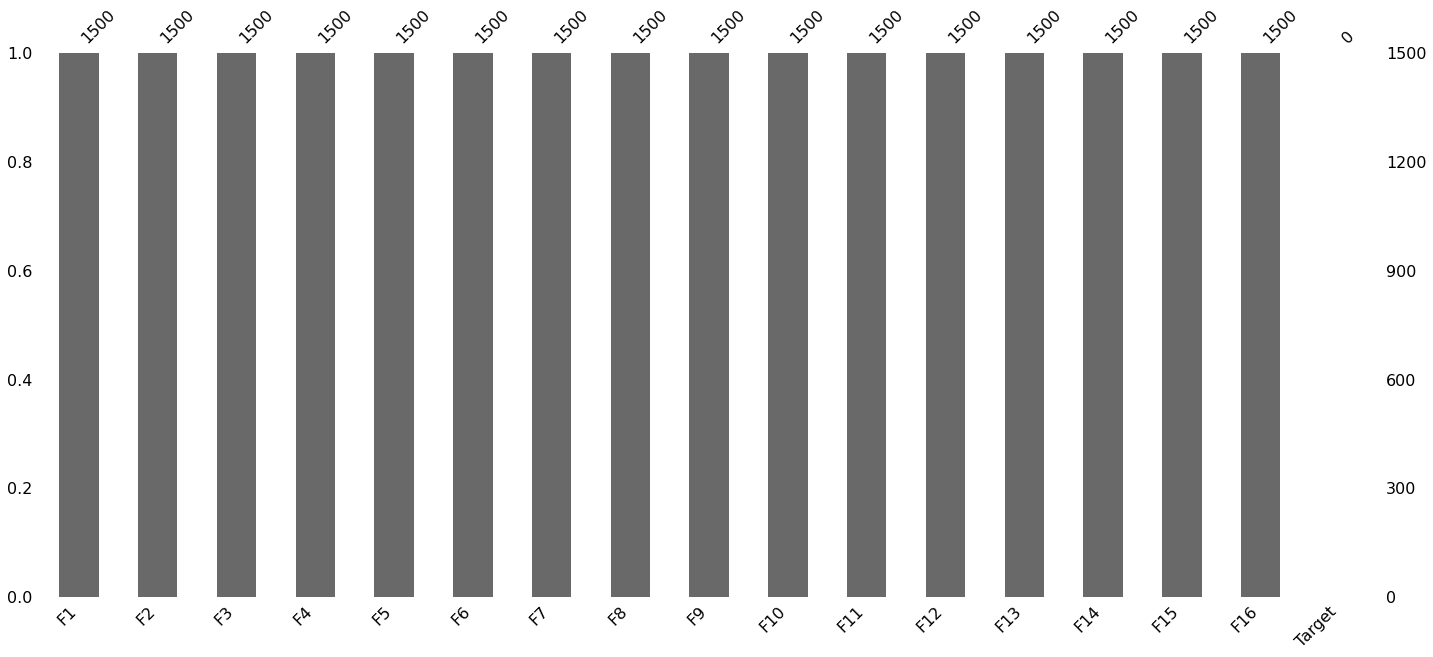

In [12]:
test_dataset=pd.read_csv('./CE802_P3_Data/CE802_P3_Test.csv')
#Checkin if there is any null for any columns 
msno.bar(test_dataset)

In [29]:
#create a copy of the dataset. to keep the originaln one
Test_df=test_dataset.copy()

# One-hot encoding of the the categorical columns - F2 and F12
Test_df=pd.get_dummies(Test_df, drop_first=False)

# Scale the input dataset based on training trasformation
test_df_scaled = scaler_x.transform(Test_df.drop(columns='Target'))

#Make prediction on the data
Predcited_values = svm_reg.predict(test_df_scaled)

#inverse the scalling, to get correct prediction in actual range
test_dataset['Target']= scaler_y.inverse_transform(Predcited_values.reshape(-1,1))
#replacing all -ve values with zeros
test_dataset['Target']=test_dataset['Target'].apply(lambda x: x if x>0 else 0)

#write to a file
test_dataset.to_csv('CE802_P3_Test.csv')